<div style="text-align:center">
    <h1>
        Deep SARSA
    </h1>
</div>

<br><br>

<div style="text-align:center">

In this notebook, we extend the SARSA algorithm to use function approximators (Neural Networks). The resulting algorithm is known as Deep SARSA.
</div>


<br>

In [4]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



# !pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation
import matplotlib.patches as mpatches

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def plot_cost_to_go(env, q_network, xlabel=None, ylabel=None):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)

    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = - q_network(q_net_input).max(dim=-1, keepdim=True)[0]
    Z = Z.reshape(100, 100).detach().numpy()
    X = X.numpy()
    Y = Y.numpy()

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylabel(ylabel, size=14)
    ax.set_title("Estimated cost-to-go", size=18)
    plt.tight_layout()
    plt.show()


def plot_max_q(env, q_network, xlabel=None, ylabel=None, action_labels=[]):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)
    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = q_network(q_net_input).argmax(dim=-1, keepdim=True)
    Z = Z.reshape(100, 100).T.detach().numpy()
    values = np.unique(Z.ravel())
    values.sort()

    plt.figure(figsize=(5, 5))
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.title("Optimal action", size=18)

    im = plt.imshow(Z, cmap='jet')
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, action_labels)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()



## Import the necessary software libraries:

In [66]:
import random
import copy
import gym
import torch
import torch.nn.functional as F#this moudule will allow us to apply some functions which we will need during the learning process
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
# from utils import plot_cost_to_go, plot_max_q, test_agent, plot_stats, seed_everything
%matplotlib inline

## Create and prepare the environment

### Create the environment

In [8]:
env = gym.make('MountainCar-v0')
seed_everything(env)

In [9]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"MountainCar env: State dimensions: {state_dims}, Number of actions: {num_actions}")

MountainCar env: State dimensions: 2, Number of actions: 3


### Prepare the environment to work with PyTorch

In [53]:
from gym import Env


class PreprocessEnv(gym.Wrapper):#when we first execute an action in the environment, we'll first pass it to this wrapper class, that will prepare it to be sent to the environment and the elements
    #that result from the execution of this action will be preprocessed by this class before we get it back
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    #wraps env.reset
    def reset(self):
        state = self.env.reset()#the state of the environment is a numpy array
        #[[0.,0.], [1.,1.]]
        return torch.from_numpy(state).unsqueeze(dim=0).float() #to understand why we wrote like this, listen to the lecture, the instructor explained it really well

    #wraps env.step
    def step(self, action):
        action = action.item()#this action will be pytorch tensor and .item() method will convert it into a python integer
        next_state, reward, done, info = self.env.step(action)
        #we have to convert next_state, reward, done into tensors in order to be processed by the pytorch library
        #and not only that, we have to prepare them in order to be included in batches of data
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float() #[[0.]]-what this means that we will have a tensor of one element because we know we are working with a single reward that we got from the envrionment
        #and the -1 will give it the extra inner dimension
        done = torch.tensor(done).view(1, -1).float()
        return next_state, reward, done, info

In [54]:
env = PreprocessEnv(env)

In [58]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state : {next_state}, Reward : {reward}, Done : {done}")

Sample state: tensor([[-0.4452,  0.0000]])
Next state : tensor([[-0.4468, -0.0016]]), Reward : tensor([[-1.]]), Done : tensor([[0.]])


In [27]:
#for testing and seeing the output
hello=np.array([20,30])

In [28]:
#for testing and seeing the output
print(hello)

[20 30]


In [29]:
#for testing and seeing the output
print(type(hello))

<class 'numpy.ndarray'>


In [30]:
#for testing and seeing the output
hello=torch.from_numpy(hello).unsqueeze(dim=0).float()

In [31]:
#for testing and seeing the output
print(hello)

tensor([[20., 30.]])


In [32]:
#for testing and seeing the output
print(type(hello))

<class 'torch.Tensor'>


In [33]:
#for testing and seeing the output
print(hello.shape)

torch.Size([1, 2])


In [23]:
#for testing and seeing the output
hello2=np.array([20,30])

In [24]:
#for testing and seeing the output
hello2=torch.from_numpy(hello2).unsqueeze(dim=1).float()

In [25]:
#for testing and seeing the output
print(hello2)

tensor([[20.],
        [30.]])


In [26]:
#for testing and seeing the output
print(hello2.shape)

torch.Size([2, 1])


In [34]:
#for testing and seeing the output
hello3=np.array([20,30])

In [37]:
#for testing and seeing the output
hello3=torch.from_numpy(hello3).float()

In [38]:
#for testing and seeing the output
print(hello3)

tensor([20., 30.])


In [39]:
#for testing and seeing the output
print(hello3.shape)

torch.Size([2])


In [42]:
#for testing and seeing the output
hi=5

In [43]:
#for testing and seeing the output
print(hi)

5


In [44]:
#for testing and seeing the output
print(type(hi))

<class 'int'>


In [45]:
#for testing and seeing the output
hi = torch.tensor(hi).view(1, -1)

In [46]:
#for testing and seeing the output
print(hi)

tensor([[5]])


In [47]:
#for testing and seeing the output
print(type(hi))

<class 'torch.Tensor'>


In [48]:
#for testing and seeing the output
print(hi.shape)

torch.Size([1, 1])


In [49]:
#for testing and seeing the output
hi2=5

In [50]:
#for testing and seeing the output
hi2=torch.tensor(hi2)

In [51]:
#for testing and seeing the output
print(hi2)

tensor(5)


In [52]:
#for testing and seeing the output
print(hi2.shape)

torch.Size([])


In [55]:
#for testing and seeing the output
bello=torch.tensor(0)

In [56]:
#for testing and seeing the output
bello

tensor(0)

In [57]:
#for testing and seeing the output
bello.item()

0

## Create the Q-Network and policy

<br><br>

### Create the Q-Network: $\hat q(s,a| \theta)$

In [61]:
q_network = nn.Sequential(
    #nn.Linear state * w + b
    nn.Linear(state_dims, 128),
    ##nn.Relu max(0, state*w +b)
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64,num_actions)
)

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

In [62]:
targe_q_network = copy.deepcopy(q_network)
targe_q_network = targe_q_network.eval()#this line of code won't allow the parameters of the target_q_network to change

In [63]:
targe_q_network

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [64]:
def policy(state, epsilon=0.):    
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

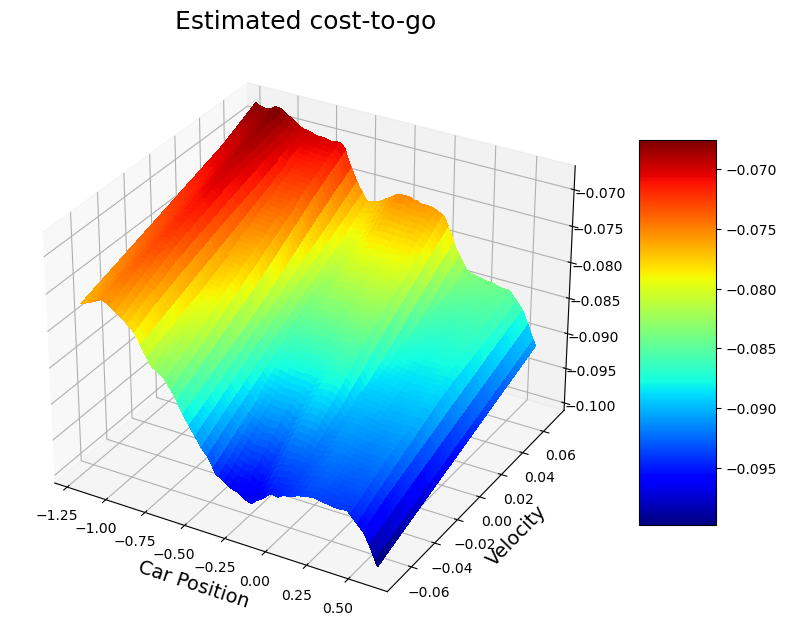

In [67]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

## Create the Experience Replay buffer

<br>
<div style="text-align:center">
    <p>A simple buffer that stores transitions of arbitrary values, adapted from
    <a href="https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training">this source.</a></p>
</div>


In [68]:
class ReplayMemory:

    def __init__(self, capacity=1000000):
        self.capacity= capacity
        self.memory = []
        self.position = 0 #tells us the position of where we have to insert at each point of time
    #insert. [s, a, r, s']

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)#what is the need for this line of code?
        self.memory[self.position]=transition
        self.position=(self.position+1) % self.capacity

    #sample [[s,a, r, s'], [s, a, r, s']]->this method will allow us to get sample of experience to update our neural network
    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        #example shape of the batch -> [[s,a,r,s'], [s',a',r',s''], [s'',a'',r'',s'''],...]
        #but actually we want [[s, s', s''], [a,a',a''], [r,r',r''],[s',s'',s''']] so that we can work with them efficiently
        batch = zip(*batch)
        #the above line of code performs the required transformation, i.e., [[s,a,r,s'], [s',a',r',s''], [s'',a'',r'',s'''],...] -> [[s, s', s'',...], [a,a',a'',...], [r,r',r'',...],[s',s'',s''',...]]
        #Now we'll convert each one of them into a pytorch tensor so that it can work with our neural network
        return [torch.cat(items) for items in batch]#it's a list which contains the tensors of the batches of the states, actions, rewards, next_states
    #can_sample -> True/False
    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size*10#when the amount of transition in the memory is at least ten times the size of the batch that we want to take, we'll be able
    #to sample batches from the memory. We wait until the memory has 10 times as many transition to avoid taking many times very similar batches.

    #__len__
    def __len__(self):
        return len(self.memory)

## Implement the algorithm

</br></br>

In [76]:
def deep_sarsa(q_network, policy, episodes, alpha=0.001, batch_size=32, gamma=0.99, epsilon=0.05):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory(capacity=1000000)
    stats = {'MSE Loss': [], 'Returns': []}
    for episode in tqdm(range(1, episodes+1)):
        state = env.reset()
        done = False
        ep_return = 0
        while not done:
            action = policy(state, epsilon)
            next_state , reward, done, _ = env.step(action)
            # print(f'This is the print statement after executing an action')
            # print(f'next_state: {next_state}, reward: {reward}, done: {done}')
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                # print(f'This is state_b: {state_b}')
                # print(f'This is action_b: {action_b}')
                # print(f'This is reward_b: {reward_b}')
                # print(f'This is done_b: {done_b}')
                # print(f'This is next_state_b: {next_state_b}')
                qsa_b = q_network(state_b).gather(1, action_b)
                # print(f"This is qsa_b: {qsa_b}")
                next_action_b = policy(next_state_b, epsilon)
                # print(f'This is next_action_b: {next_action_b}')
                next_qsa_b = targe_q_network(next_state_b).gather(1, next_action_b)
                # print(f"This is next_qsa_b: {next_qsa_b}")
                target_b = reward_b + -done_b* gamma * next_qsa_b
                # print(f"This is target_b: {target_b}")
                loss = F.mse_loss(qsa_b, target_b)
                # print(f"This is loss: {loss}")
                q_network.zero_grad()
                loss.backward()
                optim.step()
                stats['MSE Loss'].append(loss.item())
            state = next_state
            ep_return += reward.item()
        stats['Returns'].append(ep_return)

        if episode % 10 == 0:
            targe_q_network.load_state_dict(q_network.state_dict())
    
    return stats

In [77]:
stats = deep_sarsa(q_network, policy, 1500, epsilon=0.01)

100%|██████████| 1500/1500 [13:46<00:00,  1.82it/s]


NameError: name 'memory' is not defined

## Show results

### Plot execution stats

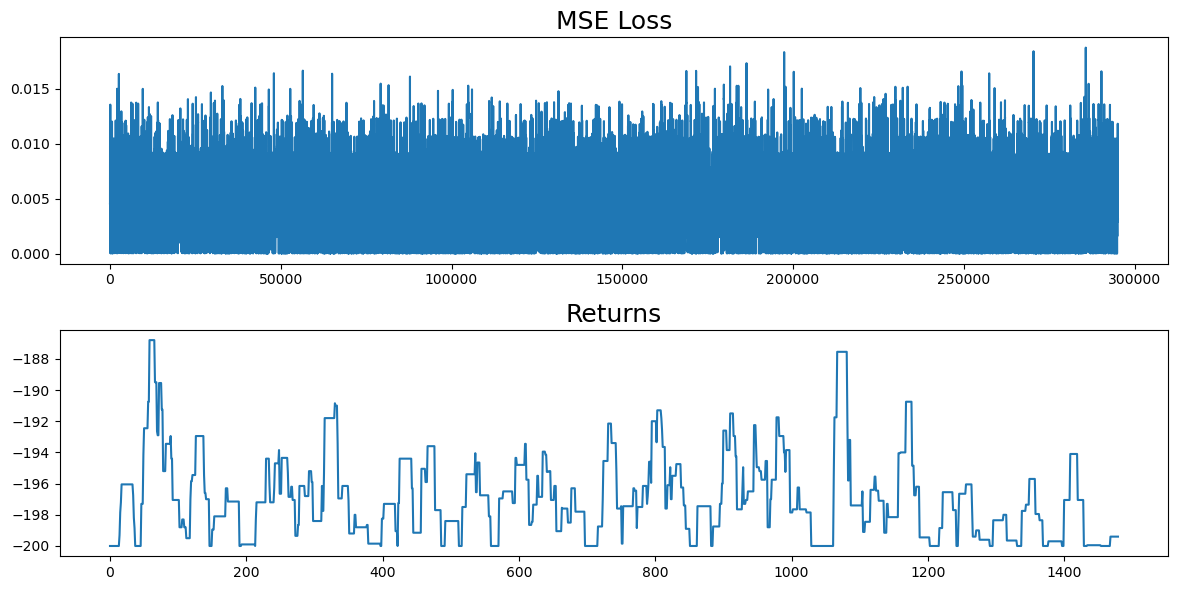

In [78]:
plot_stats(stats)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

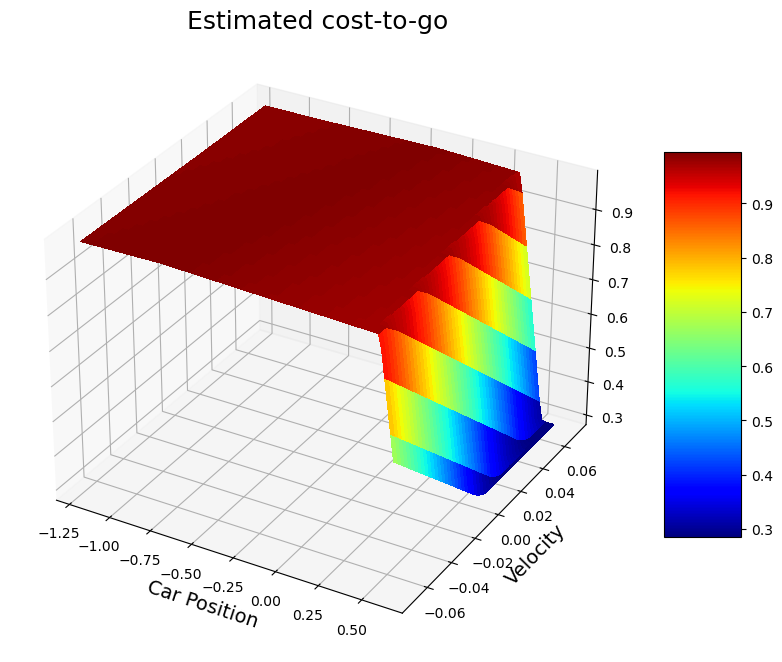

In [79]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

### Show resulting policy: $\pi(s)$

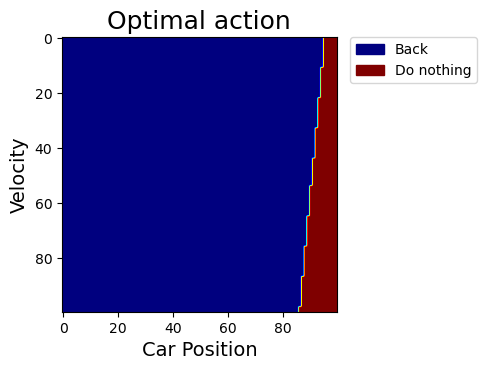

In [80]:
plot_max_q(env, q_network, xlabel='Car Position', ylabel='Velocity',
           action_labels=['Back', 'Do nothing', 'Forward'])

### Test the resulting agent

In [81]:
test_agent(env, policy, episodes=2)

: 

## Resources

[[1] Deep Reinforcement Learning with Experience Replay Based on SARSA](https://www.researchgate.net/publication/313803199_Deep_reinforcement_learning_with_experience_replay_based_on_SARSA)